# Неделя 4. Понедельник
## Нейронные сети
### PyTorch

In [1]:
import torch

# nn - модуль со слоями
from torch import nn

# optim - оптимизаторы
from torch import optim

# TensorDataset – класс датасета, с помощью которого мы укажем DataLoader что у нас за данные
from torch.utils.data import TensorDataset, DataLoader, random_split

# summary
from torchsummary import summary

from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# progress bar
from tqdm.notebook import tqdm

/Users/paveldumin/miniforge3/envs/pt/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
?make_classification

Signature:
make_classification(
    n_samples=100,
    n_features=20,
    *,
    n_informative=2,
    n_redundant=2,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=2,
    weights=None,
    flip_y=0.01,
    class_sep=1.0,
    hypercube=True,
    shift=0.0,
    scale=1.0,
    shuffle=True,
    random_state=None,
)
Docstring:
Generate a random n-class classification problem.

This initially creates clusters of points normally distributed (std=1)
about vertices of an ``n_informative``-dimensional hypercube with sides of
length ``2*class_sep`` and assigns an equal number of clusters to each
class. It introduces interdependence between these features and adds
various types of further noise to the data.

Without shuffling, ``X`` horizontally stacks features in the following
order: the primary ``n_informative`` features, followed by ``n_redundant``
linear combinations of the informative features, followed by ``n_repeated``
duplicates, drawn randomly with replacement from the infor

In [2]:
# зададим синтетические данные для примера
# 20 признаков, два класса, 100000 объектов
n_features = 15
X, y = make_classification(n_samples=100000, n_features=n_features, n_redundant=4, random_state=10, class_sep=2)
X.shape, y.shape

((100000, 15), (100000,))

In [3]:
# сделаем dataframe для seaborn
df = pd.DataFrame(np.concatenate([X, y[:, np.newaxis]],axis=1))
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.372544,0.149667,-1.829788,-0.710564,0.172706,-0.753473,3.219539,-2.258949,0.689458,0.215635,0.564078,0.347763,1.052765,-2.066468,0.068826,0.0
1,-0.920162,-1.471595,-3.181971,-2.302627,0.078188,0.191089,2.898332,-3.336875,-1.467591,0.047672,-0.734148,-0.166591,0.870139,-0.284713,-0.042125,0.0
2,-0.867346,-0.714984,-2.308342,1.355378,-0.165081,0.253880,2.210411,-2.444333,-0.958174,0.773928,-0.464096,-1.583906,0.319182,-0.338673,-0.512475,0.0
3,-2.593742,-0.488281,-2.770813,-1.514421,-0.074888,0.413238,3.281355,-3.071604,-0.529921,-0.775045,-0.158164,0.334897,-0.409302,-1.176140,0.971471,0.0
4,-0.207870,-0.693828,-2.322182,0.968451,1.672065,-1.305289,0.389738,-2.057347,-2.774857,-1.443170,-1.631638,0.104118,1.234805,1.906438,2.120509,1.0


In [4]:
n_features

15

In [13]:
# зададим модель: на вход будет поступать n_featuers признаков (в нашем случае 15)
# Решаем задачу бинарной классификации, на выходе 1 значение.
model = nn.Sequential(
    nn.Linear(n_features, 1),
    nn.Sigmoid()
)

summary(model, (n_features, ), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [128, 1]              16
           Sigmoid-2                   [128, 1]               0
Total params: 16
Trainable params: 16
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


Фактически мы задали обычную логистическую регрессию: 

$$\sigma = \dfrac{1}{1+ \exp^{-\sum_{i=0}^{i=20}x_i w_i}}$$

### Подготовка датасета

Будем использовать `TensorDataset`, он подходит нам, потому что мы работаем с табличными данными. Для картинок будем использовать аналогичный специальный класс, об этом позже. 

In [121]:
?TensorDataset

Init signature: TensorDataset(*args, **kwds)
Docstring:     
Dataset wrapping tensors.

Each sample will be retrieved by indexing tensors along the first dimension.

Args:
    *tensors (Tensor): tensors that have the same size of the first dimension.
File:           ~/miniforge3/envs/pt/lib/python3.8/site-packages/torch/utils/data/dataset.py
Type:           type
Subclasses:     


In [5]:
# основной тип данных pytorch - тензор, все данные должны быть в таком формате
dataset = TensorDataset(torch.Tensor(X), torch.Tensor(y))

In [6]:
dataset.tensors

(tensor([[-0.3725,  0.1497, -1.8298,  ...,  1.0528, -2.0665,  0.0688],
         [-0.9202, -1.4716, -3.1820,  ...,  0.8701, -0.2847, -0.0421],
         [-0.8673, -0.7150, -2.3083,  ...,  0.3192, -0.3387, -0.5125],
         ...,
         [-0.3653, -0.4037, -0.8965,  ...,  0.5988, -2.7247, -1.7125],
         [ 0.4481, -0.9918,  1.6985,  ...,  2.2344,  2.3127, -0.2746],
         [-2.1550,  0.3902,  1.4244,  ..., -0.8463, -2.4391, -0.3963]]),
 tensor([0., 0., 0.,  ..., 0., 1., 0.]))

In [7]:
# аналог train_test_split для pytorch
train_ds, valid_ds = random_split(dataset, (70000, 30000))

In [9]:
# DataLoader – загрузчик данных для pytorch, 
# он оптимизирует процесс чтения данных и позволяет более эффективно использовать ресурсы компьютера
train_loader = DataLoader(train_ds, shuffle=True, batch_size=32)
valid_loader = DataLoader(valid_ds, shuffle=True, batch_size=32)

In [10]:
next(iter(train_loader))

[tensor([[-1.7583,  0.3608, -0.5876,  0.1320, -1.7963, -2.0215,  2.8971, -1.1335,
           2.0613,  0.5306,  1.3645,  2.1205,  0.5699, -2.9466, -0.0196],
         [-1.7034, -0.3682,  1.6256, -0.6931, -0.3074, -2.0884,  0.3477,  1.3043,
           2.5552,  0.5352,  1.5363, -0.6784,  0.1721, -2.0949,  0.4311],
         [ 0.1809, -0.4636,  0.6682, -0.2211,  1.5800, -0.8583, -2.3896,  1.0907,
          -1.4505, -1.5802, -0.9770, -0.0983,  0.0216,  2.2420,  0.0244],
         [-0.6702, -0.7688,  1.2426,  1.6691,  1.0234, -0.7132, -2.7389,  1.6550,
          -1.0138,  1.8925, -0.7340,  2.0839, -0.3286,  2.0803, -1.9305],
         [-0.0662,  2.5638, -1.4399,  1.1460, -2.2458,  1.4896,  2.7170, -1.8178,
           0.7237, -1.1392,  0.5604, -1.1185,  0.8911, -1.8509,  1.1927],
         [ 0.1015,  0.9655,  2.7007, -1.7070,  1.0545, -1.0159, -0.7588,  2.4596,
           2.9255, -0.9534,  1.7035, -0.3124,  0.9768, -1.8428,  1.2518],
         [-0.8014, -1.2761, -3.0332,  1.3802, -0.3314, -1.5348, 

In [11]:
# Зададим функцию для отрисовки графиков

def plot_loss_metrics(tl: list, vl: list, tm: list, vm: list):

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(tl, label='Train loss')
    ax[0].plot(vl, label='Valid Loss')
    ax[0].legend()
    ax[0].set_title('Loss')

    ax[1].plot(tm, label='Train accuracy')
    ax[1].plot(vm, label='Valid accuracy')
    ax[1].legend()
    ax[1].set_title('Accuracy')

### Обучение модели

В TensorFlow и pytorch процесс обучения модели программируется вручную, это позволяет более детально следить за процессом и контролировать параметры. Обычно цикл обучения реализуется функцией, но мы попробуем начать с обычного цикла. Процесс итеративный: одна эпоха заканчивается, когда все данные прошли через сеть. 

In [15]:
next(iter(model.parameters()))

Parameter containing:
tensor([[-0.0354,  0.1959,  0.1309, -0.0209, -0.0601,  0.2500,  0.1175, -0.0046,
         -0.0846, -0.0729, -0.2239, -0.0916, -0.0483, -0.1110,  0.0392]],
       requires_grad=True)

In [24]:
next(iter(model.parameters()))

Parameter containing:
tensor([[-0.0349,  0.0272,  0.1751, -0.0094, -0.0109,  0.0071, -0.9283,  0.2620,
         -1.0571, -0.0377, -0.8523,  0.0710,  0.0077,  1.1251,  0.0329]],
       requires_grad=True)

In [18]:
# задаем оптимизатор – алгоритм градиентного спуска, который будет искать решение задачи: минимум функции потерь
optimizer = optim.SGD(model.parameters(), lr=0.01) 

Формула бинарной кросс-энтропии: 

$$BCELoss = -\sum_{i}^{N}\big(y_i \log p_i + (1-y_i)\log(1-p_i)\big)$$

In [19]:

# решаем задачу бинарной классификации: будем минимизировать бинарную кросс-энтропию (BCE - Binary Cross Entropy)
criterion = torch.nn.BCELoss() 

In [20]:
def fit_model(model: torch.nn.modules.container.Sequential, n_epochs: int) -> tuple:

    # будем сохранять историю обучения модели: значения функции потерь и метрики accuracy
    # эти переменные будут отвечать за хранение значений после вычисления каждой эпохи 
    train_losses = []
    valid_losses = []

    train_metric = []
    valid_metric = []
    for epoch in range(n_epochs): 
        ####### ОБУЧЕНИЕ ##########
        model.train() # устанавливаем модель в режим обучения – сейчас будут вычисляться градиенты

        # эти два списка будут хранить значения внутри одной итерации 
        train_loss_iter = []
        train_metric_iter = []
        
        # внутри одной эпохи итерируемся по загрузчику: обычно памяти меньше, 
        # чем данных, поэтому сразу взять всю выборку не получится
        for samples, labels in train_loader:

            # получаем предсказания модели, т.е. делаем прямой проход – forward pass
            predictions = model(samples)

            # на выходе из модели форма predictions (16, 1), а форма labels – (16, )
            # нам нужно убрать одно измерение из predictions, это можно сделать с 
            # помощью метода squeeze(-1)
            predictions = predictions.squeeze(-1)

            # считаем значение функции потерь: сравниваем 
            # прогнозы модели с истинными значениями классов
            loss = criterion(predictions, labels)

            # обнуляем значения градиентов с предыдущего шага – pytorch этого не делает за нас
            optimizer.zero_grad() 

            # делаем обратный проход – backward
            loss.backward()

            # применяем вычисленные градиенты к параметрам
            optimizer.step()

            # запишем loss в список
            train_loss_iter.append(loss.item())

            # вычислим точность: число совпавших классов в предсказании модели и настоящих меток
            # 
            accuracy = (torch.round(predictions) == labels).sum()/len(samples)
            train_metric_iter.append(accuracy)

        ###### ВАЛИДАЦИЯ ###########
        # Теперь будем идти по валидационному загрузчику и проверять качество модели на другой выборке
        # переводим модель в режим валидации
        model.eval()

        valid_loss_iter = []
        valid_metric_iter = []

        for samples, labels in valid_loader:

            # получаем предсказания модели, т.е. делаем прямой проход – forward pass
            predictions = model(samples)

            # на выходе из модели форма predictions (16, 1), а форма labels – (16, )
            # нам нужно убрать одно измерение из predictions, это можно сделать с 
            # помощью метода squeeze(-1)
            predictions = predictions.squeeze(-1)

            # считаем значение функции потерь: сравниваем прогнозы модели с истинными значениями классов
            loss = criterion(predictions, labels)

            
            # запишем loss в список, item() забирает только значение из переменной, не тянет за собой техническую информацию
            valid_loss_iter.append(loss.item())

            # вычислим точность: число совпавших классов в предсказании модели и настоящих меток
            # 
            accuracy = (torch.round(predictions) == labels).sum()/len(samples)
            valid_metric_iter.append(accuracy)
        
        
        # после окончания эпохи запишем все усредненные характеристики в переменные 
        train_losses.append(np.mean(train_loss_iter))
        valid_losses.append(np.mean(valid_loss_iter))

        train_metric.append(np.mean(train_metric_iter))
        valid_metric.append(np.mean(valid_metric_iter))
        if epoch % 1 == 0:
            print(f'Epoch {epoch} finished: train_loss={train_losses[-1]:.3f}, valid_loss={valid_losses[-1]:.3f}')
    return train_losses, valid_losses, train_metric, valid_metric




In [21]:
print(f'Model: \n{model}, \n optimmizer: {optimizer}, \n loss: {criterion}')

Model: 
Sequential(
  (0): Linear(in_features=15, out_features=1, bias=True)
  (1): Sigmoid()
), 
 optimmizer: SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
), 
 loss: BCELoss()


In [22]:
train_losses, valid_losses, train_metric, valid_metric = fit_model(model, 15)

Epoch 0 finished: train_loss=0.062, valid_loss=0.042
Epoch 1 finished: train_loss=0.039, valid_loss=0.041
Epoch 2 finished: train_loss=0.038, valid_loss=0.041
Epoch 3 finished: train_loss=0.038, valid_loss=0.040
Epoch 4 finished: train_loss=0.038, valid_loss=0.040
Epoch 5 finished: train_loss=0.038, valid_loss=0.040
Epoch 6 finished: train_loss=0.038, valid_loss=0.040
Epoch 7 finished: train_loss=0.038, valid_loss=0.040
Epoch 8 finished: train_loss=0.038, valid_loss=0.040
Epoch 9 finished: train_loss=0.038, valid_loss=0.040
Epoch 10 finished: train_loss=0.038, valid_loss=0.040
Epoch 11 finished: train_loss=0.038, valid_loss=0.040
Epoch 12 finished: train_loss=0.038, valid_loss=0.040
Epoch 13 finished: train_loss=0.038, valid_loss=0.040
Epoch 14 finished: train_loss=0.038, valid_loss=0.040


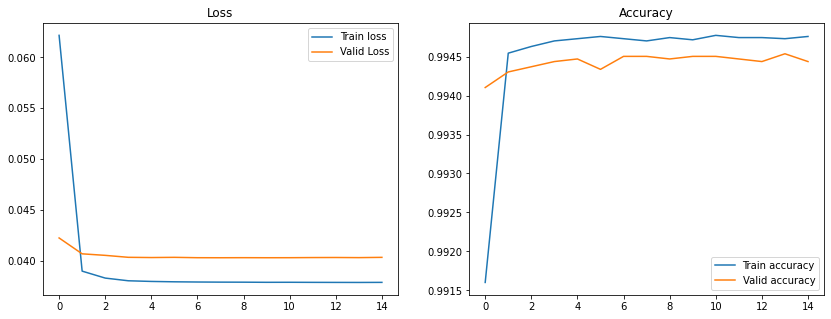

In [23]:
# Обучение прошло, теперь надо визуализировать лоссы и метрики: только по графикам можно понять, обучилась ли модель

plot_loss_metrics(train_losses, valid_losses, train_metric, valid_metric)

In [25]:
# Можно посмотреть на значения параметров
# requires_grad означает, что эти параметры участвуют в обучении сети. 
# Иногда мы будем их «выключать», т. е. устанавливать это поле в False

for param in model.parameters():
    print(param)

Parameter containing:
tensor([[-0.0349,  0.0272,  0.1751, -0.0094, -0.0109,  0.0071, -0.9283,  0.2620,
         -1.0571, -0.0377, -0.8523,  0.0710,  0.0077,  1.1251,  0.0329]],
       requires_grad=True)
Parameter containing:
tensor([-0.1991], requires_grad=True)


Обычный вопрос: 
> сколько нейронов и слоев необходимо выбирать для решения задачи? 

Исчерпывающего ответа **нет**, можно почитать ответы на [stats.stackexchange.com](https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw)

In [31]:
# Зададим другую модель

model = nn.Sequential(
    nn.Linear(n_features, 32),
    nn.Dropout(),
    nn.Sigmoid(),
    nn.Linear(32, 16),
    nn.Dropout(),
    nn.Sigmoid(),
    nn.Linear(16, 1),
    nn.Sigmoid()

)

summary(model, (n_features, ), batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [64, 32]             512
           Dropout-2                   [64, 32]               0
           Sigmoid-3                   [64, 32]               0
            Linear-4                   [64, 16]             528
           Dropout-5                   [64, 16]               0
           Sigmoid-6                   [64, 16]               0
            Linear-7                    [64, 1]              17
           Sigmoid-8                    [64, 1]               0
Total params: 1,057
Trainable params: 1,057
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.00
Estimated Total Size (MB): 0.08
----------------------------------------------------------------


In [32]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = torch.nn.BCELoss()

In [33]:
tl, vl, tm, vm = fit_model(model, 20)

Epoch 0 finished: train_loss=0.648, valid_loss=0.482
Epoch 1 finished: train_loss=0.321, valid_loss=0.066
Epoch 2 finished: train_loss=0.122, valid_loss=0.036
Epoch 3 finished: train_loss=0.077, valid_loss=0.035
Epoch 4 finished: train_loss=0.061, valid_loss=0.037
Epoch 5 finished: train_loss=0.053, valid_loss=0.040
Epoch 6 finished: train_loss=0.048, valid_loss=0.042
Epoch 7 finished: train_loss=0.045, valid_loss=0.043
Epoch 8 finished: train_loss=0.044, valid_loss=0.044
Epoch 9 finished: train_loss=0.042, valid_loss=0.046
Epoch 10 finished: train_loss=0.041, valid_loss=0.047
Epoch 11 finished: train_loss=0.040, valid_loss=0.048
Epoch 12 finished: train_loss=0.040, valid_loss=0.049
Epoch 13 finished: train_loss=0.039, valid_loss=0.049
Epoch 14 finished: train_loss=0.038, valid_loss=0.050
Epoch 15 finished: train_loss=0.039, valid_loss=0.051
Epoch 16 finished: train_loss=0.039, valid_loss=0.051
Epoch 17 finished: train_loss=0.038, valid_loss=0.052
Epoch 18 finished: train_loss=0.038, v

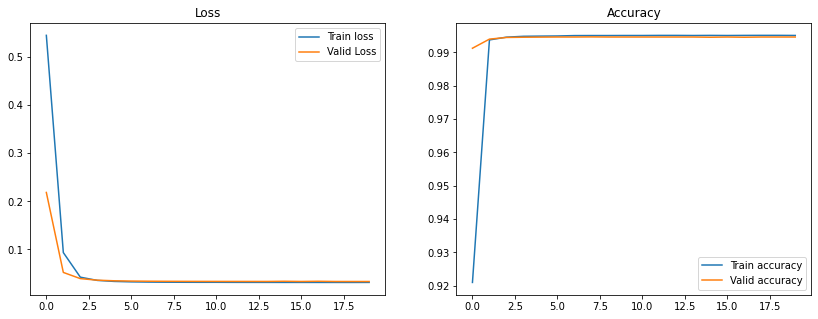

In [30]:
# Обучение прошло, теперь надо визуализировать лоссы и метрики: 
# только по графикам можно понять, обучилась ли модель
plot_loss_metrics(tl, vl, tm, vm)

In [34]:
# Зададим модель еще сложнее

model = nn.Sequential(
    nn.Linear(n_features, 512),
    nn.Sigmoid(),
    nn.Linear(512, 256),
    nn.Sigmoid(),
    nn.Linear(256, 128),
    nn.Sigmoid(),
    nn.Linear(128, 128),
    nn.Sigmoid(),
    nn.Linear(128, 1),
    nn.Sigmoid()

)

summary(model, (n_features, ), batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [64, 512]           8,192
           Sigmoid-2                  [64, 512]               0
            Linear-3                  [64, 256]         131,328
           Sigmoid-4                  [64, 256]               0
            Linear-5                  [64, 128]          32,896
           Sigmoid-6                  [64, 128]               0
            Linear-7                  [64, 128]          16,512
           Sigmoid-8                  [64, 128]               0
            Linear-9                    [64, 1]             129
          Sigmoid-10                    [64, 1]               0
Total params: 189,057
Trainable params: 189,057
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.00
Params size (MB): 0.72
Estimated T

In [35]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = torch.nn.BCELoss()
tl, vl, tm, vm = fit_model(model, 20)

Epoch 0 finished: train_loss=0.694, valid_loss=0.695
Epoch 1 finished: train_loss=0.693, valid_loss=0.694
Epoch 2 finished: train_loss=0.692, valid_loss=0.690
Epoch 3 finished: train_loss=0.689, valid_loss=0.685
Epoch 4 finished: train_loss=0.673, valid_loss=0.647
Epoch 5 finished: train_loss=0.388, valid_loss=0.085
Epoch 6 finished: train_loss=0.050, valid_loss=0.040
Epoch 7 finished: train_loss=0.036, valid_loss=0.037
Epoch 8 finished: train_loss=0.034, valid_loss=0.036
Epoch 9 finished: train_loss=0.034, valid_loss=0.036
Epoch 10 finished: train_loss=0.034, valid_loss=0.036
Epoch 11 finished: train_loss=0.034, valid_loss=0.036
Epoch 12 finished: train_loss=0.034, valid_loss=0.036
Epoch 13 finished: train_loss=0.033, valid_loss=0.036
Epoch 14 finished: train_loss=0.033, valid_loss=0.035
Epoch 15 finished: train_loss=0.033, valid_loss=0.035
Epoch 16 finished: train_loss=0.033, valid_loss=0.035
Epoch 17 finished: train_loss=0.033, valid_loss=0.035
Epoch 18 finished: train_loss=0.033, v

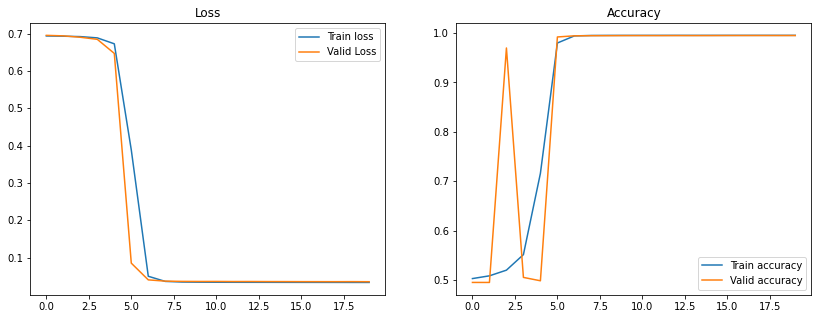

In [36]:
plot_loss_metrics(tl, vl, tm, vm)